# Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from dictionary import column_mapping
import textwrap

sns.set_theme()

# 4. Modelling

This chapter focuses on the modelling phase. We will apply some machine learning techniques to explore and model the relationships between relevant variables and student's performance.

In [2]:
df = pd.read_csv("../../../databases/q1_database.csv")
df = df.drop(columns=["Avg Reading Result"])
df.sample(5)

,Avg Math Result,BMMJ1,CNT_Group,CREATOOS,ESCS,FAMCON,HISEI,HOMEPOS,IC171Q02JA,IC173Q04JA,...,ST289Q02JA,ST289Q05WA,ST289Q06JA,ST289Q10WA,ST290Q01WA,ST290Q02WA,ST290Q03WA,ST290Q05WA,ST291Q01JA,ST355Q02JA
229642,450.3536,85.41,Above Average,NaN,1.4594,NaN,85.41,1.3095,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN,NaN
122545,405.6094,23.47,Below Average,1.4317,-1.6933,-0.5551,23.47,-1.7746,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN
308029,308.6742,17.00,Below Average,NaN,-1.2384,NaN,17.00,-0.4122,2.0,NaN,...,NaN,3.0,NaN,5.0,1.0,NaN,NaN,3.0,NaN,1.0
269571,415.3148,NaN,Above Average,0.4752,0.8534,-1.8879,75.13,-0.0417,1.0,NaN,...,1.0,NaN,1.0,NaN,2.0,NaN,3.0,NaN,NaN,NaN
60259,356.7108,14.64,Below Average,0.5729,-0.6983,0.1406,51.50,-1.6740,4.0,1.0,...,NaN,NaN,NaN,3.0,3.0,NaN,2.0,NaN,2.0,NaN


In [3]:
y = df["Avg Math Result"]
X = df.drop(columns=["Avg Math Result"])

repeat_col = X["REPEAT"]
X = X.drop(columns=["REPEAT"])

## Step 1 - Pre-process

We began by pre-processing the dataset, to ensure it was suitable for use in the selected models. 

For categorical variables, we applied **OneHotEncoding** to convert them into a numerical format. For numerical features, we first handled missing values by applying an **imputation** strategy, replacing null values with the mean of each column. Afterward, we used a **StandardScaler** to normalize the numerical features and bring them to a similar scale.

In [4]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

numerical_transformer = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    [
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

X_encoded = preprocessor.fit_transform(X)

onehot_columns = preprocessor.named_transformers_["cat"][
    "onehot"
].get_feature_names_out(categorical_cols)
final_columns = list(numerical_cols) + list(onehot_columns)


X_encoded_df = pd.DataFrame(X_encoded, columns=final_columns)

X_encoded_df["REPEAT"] = repeat_col.reset_index(drop=True)

X_encoded_repeating = X_encoded_df[X_encoded_df["REPEAT"] == 1].drop(columns=["REPEAT"])
X_encoded_not_repeating = X_encoded_df[X_encoded_df["REPEAT"] == 0].drop(
    columns=["REPEAT"]
)

## Step 2 – K-Means

As a second step, we applied an unsupervised learning technique — K-Means clustering — to group the data into three clusters. This approach allowed us to identify patterns and similarities among students, enabling a better understanding of the different profiles that may influence mathematics performance.

We separated them in two groups, repeating and non-repeating, in order to compare how the profiles differ between these two.

In [5]:
kmeans_repeating = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X_encoded_repeating)
kmeans_not_repeating = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X_encoded_not_repeating)

In [6]:
repeating = df[df["REPEAT"] == 1].reset_index(drop=True)
repeating["kmeans"] = kmeans_repeating.labels_
X_encoded_repeating["kmeans"] = kmeans_repeating.labels_

not_repeating = df[df["REPEAT"] == 0].reset_index(drop=True)
not_repeating["kmeans"] = kmeans_not_repeating.labels_
X_encoded_not_repeating["kmeans"] = kmeans_not_repeating.labels_

print(repeating.groupby("kmeans")["Avg Math Result"].describe().to_string())
print(not_repeating.groupby("kmeans")["Avg Math Result"].describe().to_string())

          count        mean        std       min         25%        50%         75%       max
kmeans                                                                                       
0       12082.0  348.688187  59.561334  122.8485  306.382700  341.74345  384.130575  661.8582
1       27562.0  399.065672  86.056714   97.6254  334.370125  390.61020  453.875400  763.4544
2       20108.0  323.481965  51.646285   39.1713  290.204850  318.80540  352.623250  636.7595
           count        mean        std       min         25%       50%         75%       max
kmeans                                                                                       
0       217455.0  427.887344  73.245294  105.7688  375.064300  424.4471  476.263250  776.9333
1       110462.0  370.076523  63.497353  121.7875  325.901425  363.1559  407.212375  759.3522
2       179907.0  524.622476  83.578745  189.7535  469.300000  526.5810  581.517000  843.2881


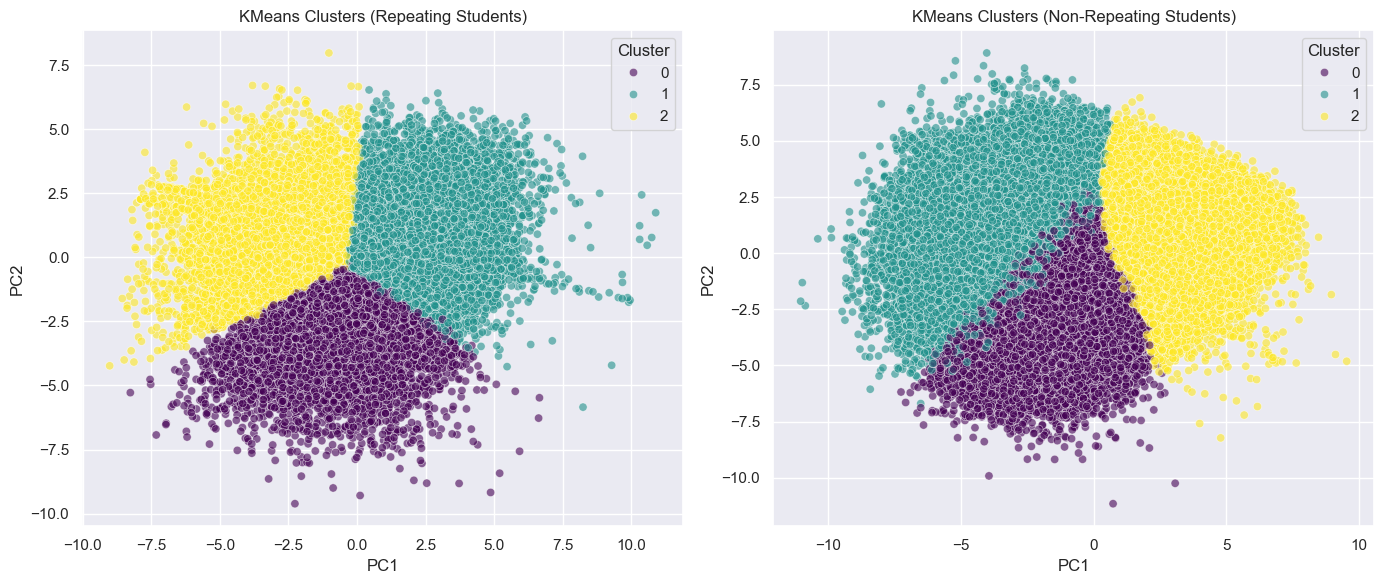

In [7]:
# repeating pca
pca_repeating = PCA(n_components=2)
X_pca_repeating = pca_repeating.fit_transform(X_encoded_repeating)
X_pca_repeating_df = pd.DataFrame(X_pca_repeating, columns=["PC1", "PC2"])
X_pca_repeating_df["Cluster"] = kmeans_repeating.labels_

# not repeating pca
pca_not_repeating = PCA(n_components=2)
X_pca_not_repeating = pca_not_repeating.fit_transform(X_encoded_not_repeating)
X_pca_not_repeating_df = pd.DataFrame(X_pca_not_repeating, columns=["PC1", "PC2"])
X_pca_not_repeating_df["Cluster"] = kmeans_not_repeating.labels_

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(
    data=X_pca_repeating_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_title("KMeans Clusters (Repeating Students)")

sns.scatterplot(
    data=X_pca_not_repeating_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_title("KMeans Clusters (Non-Repeating Students)")
plt.tight_layout()
plt.show()

In [8]:
means = repeating.groupby("kmeans")["Avg Math Result"].mean()
ordered_labels = means.sort_values().index.tolist()

label_map = {old_label: new_label for new_label, old_label in enumerate(ordered_labels)}

repeating["kmeans"] = repeating["kmeans"].map(label_map)
X_encoded_repeating["kmeans"] = X_encoded_repeating["kmeans"].map(label_map)

means_nonrep = not_repeating.groupby("kmeans")["Avg Math Result"].mean()
ordered_labels_nonrep = means_nonrep.sort_values().index.tolist()
label_map_nonrep = {
    old_label: new_label for new_label, old_label in enumerate(ordered_labels_nonrep)
}
not_repeating["kmeans"] = not_repeating["kmeans"].map(label_map_nonrep)
X_encoded_not_repeating["kmeans"] = X_encoded_not_repeating["kmeans"].map(
    label_map_nonrep
)

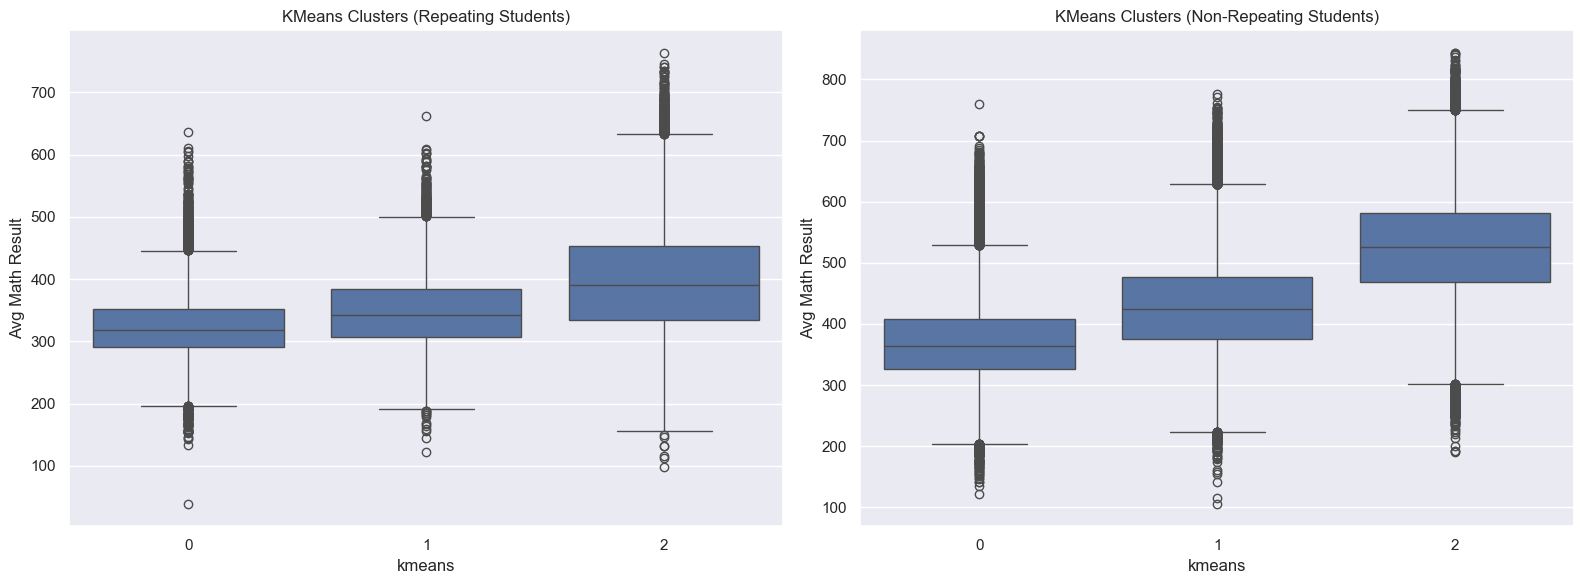

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(
    data=repeating,
    x="kmeans",
    y="Avg Math Result",
    ax=axes[0],
)
axes[0].set_title("KMeans Clusters (Repeating Students)")

sns.boxplot(
    data=not_repeating,
    x="kmeans",
    y="Avg Math Result",
    ax=axes[1],
)
axes[1].set_title("KMeans Clusters (Non-Repeating Students)")

plt.tight_layout()
plt.show()

Boxplots interessantes para além do target 

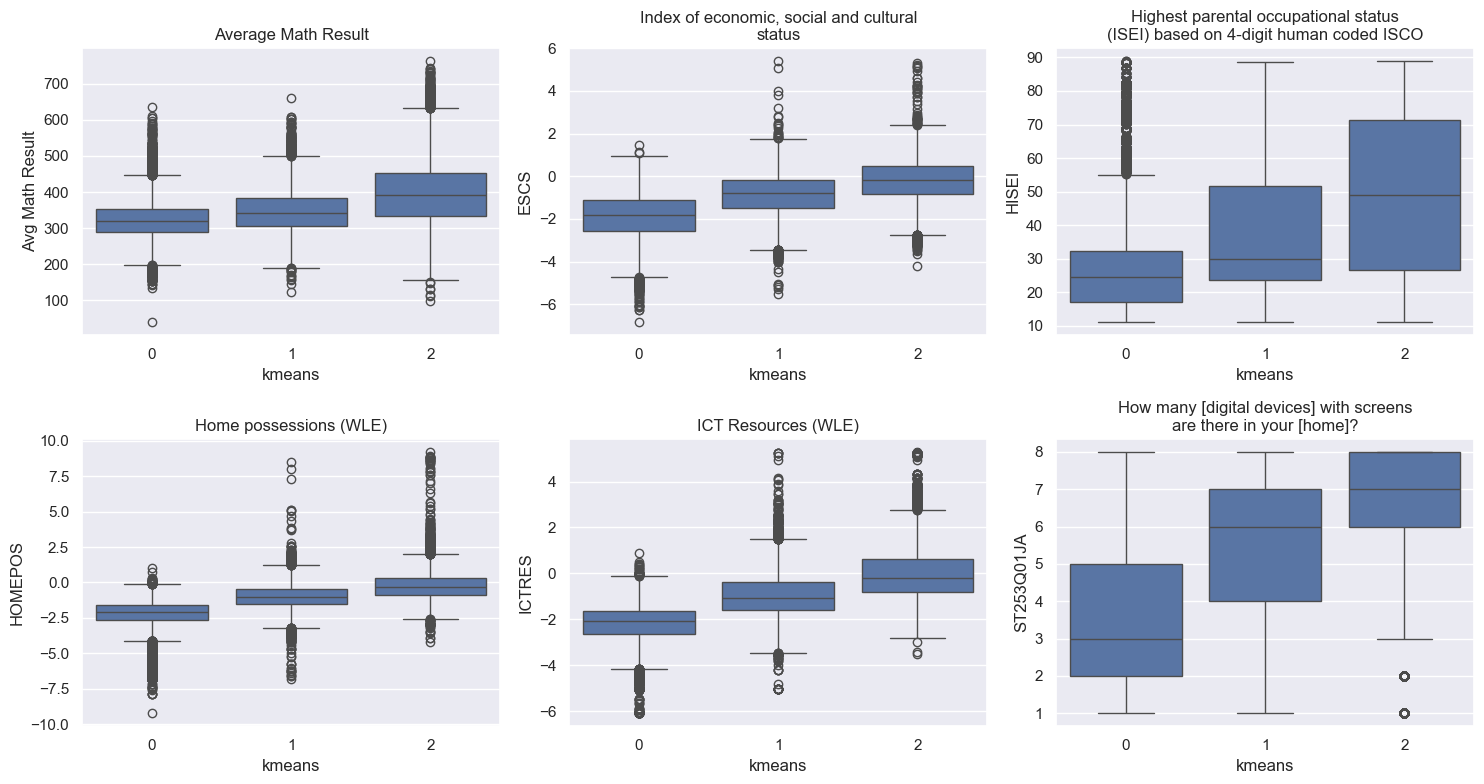

In [10]:
columns_to_plot = [
    "Avg Math Result",
    "ESCS",
    "HISEI",
    "HOMEPOS",
    "ICTRES",
    "ST253Q01JA",
]

n_cols = 3
n_rows = -(-len(columns_to_plot) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.boxplot(data=repeating, x="kmeans", y=column, ax=axes[i])
    title = column_mapping.get(column, column)
    wrapped_title = "\n".join(textwrap.wrap(title, width=40))
    axes[i].set_title(wrapped_title)
    axes[i].tick_params(axis="x")

for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
centroids_repeating = pd.DataFrame(
    kmeans_repeating.cluster_centers_,
    columns=X_encoded_repeating.drop(columns="kmeans").columns,
)
print(centroids_repeating.to_string())

      BMMJ1  CREATOOS      ESCS    FAMCON     HISEI   HOMEPOS  IC171Q02JA  IC173Q04JA  IC177Q07JA    ICTRES   MATHEFF      OECD  ST059Q02JA  ST250Q02JA  ST251Q06JA  ST253Q01JA  ST255Q01JA  ST256Q03JA  ST289Q02JA  ST289Q05WA  ST289Q06JA  ST289Q10WA  ST290Q01WA  ST290Q02WA  ST290Q03WA  ST290Q05WA  ST291Q01JA  ST355Q02JA  CNT_Group_Above Average  CNT_Group_Average  CNT_Group_Below Average
0 -0.373227  0.222905 -0.460316 -1.170999 -0.442973 -0.436931   -0.575442   -0.365206    0.205941 -0.207883 -1.092213  0.046812   -0.461137    0.100604   -0.258238   -0.335831   -0.543574   -0.389470   -1.127944   -1.113598   -1.160083   -0.820510   -0.769717   -0.712241   -0.750650   -0.850505   -0.741291   -0.424932                 0.417960           0.093348                 0.488693
1 -0.071273  0.117830  0.098368  0.044478 -0.066609  0.200118   -0.025911   -0.005508    0.117564  0.288968  0.135653  0.305014   -0.050915   -0.273224    0.070140    0.192186   -0.052066   -0.088726    0.080839   -0.00117

## Step 3 - Supervised Learning Aproach (Random Forest Classifier)

In this step, we implemented another machine learning technique, this time a supervised learning aproach, using a Random Forest Classifier. The main objective was to identify the most important features influencing student's mathematics performance, not only for the entire dataset, but also for each of the clusters obtained in the previous step.

In [12]:
def plot_feature_importances(importance_df, cluster_id=None, mapping=column_mapping):
    melted_df = importance_df.reset_index().melt(
        id_vars="index", var_name="Group", value_name="Importance"
    )
    melted_df.rename(columns={"index": "Feature"}, inplace=True)

    melted_df["Feature"] = (
        melted_df["Feature"]
        .map(mapping)
        .fillna(melted_df["Feature"])
        .apply(lambda x: "\n".join(textwrap.wrap(x, 60)))
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(data=melted_df, y="Feature", x="Importance", hue="Group")
    if cluster_id is not None:
        plt.title(
            f"Top Feature Importances for Cluster {cluster_id} (Repeating vs Non-Repeating)"
        )
    else:
        plt.title(
            f"Top Feature Importances (Repeating vs Non-Repeating)"
        )
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()

Top features obtained for cluster 0, Repeating vs Non-Repeating

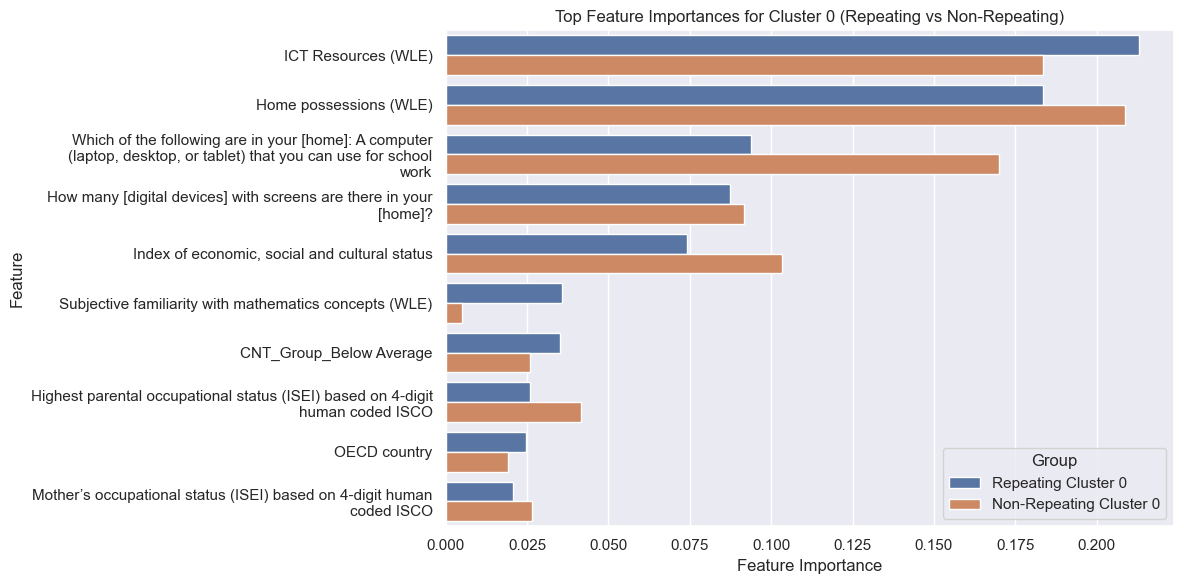

In [13]:
# Cluster 0
X_0_repeating = X_encoded_repeating.copy()
X_0_repeating["cluster_0"] = (X_0_repeating["kmeans"] == 0).astype(int)

X_rep = X_0_repeating.drop(columns=["kmeans", "cluster_0"])
y_rep = X_0_repeating["cluster_0"]

model_rep = RandomForestClassifier(random_state=42)
model_rep.fit(X_rep, y_rep)

importances_rep = pd.Series(model_rep.feature_importances_, index=X_rep.columns)

X_0_not_repeating = X_encoded_not_repeating.copy()
X_0_not_repeating["cluster_0"] = (X_0_not_repeating["kmeans"] == 0).astype(int)

X_nonrep = X_0_not_repeating.drop(columns=["kmeans", "cluster_0"])
y_nonrep = X_0_not_repeating["cluster_0"]

model_nonrep = RandomForestClassifier(random_state=42)
model_nonrep.fit(X_nonrep, y_nonrep)

importances_nonrep = pd.Series(
    model_nonrep.feature_importances_, index=X_nonrep.columns
)

importance_df = pd.DataFrame(
    {
        "Repeating Cluster 0": importances_rep,
        "Non-Repeating Cluster 0": importances_nonrep,
    }
)

top_features = (
    (importances_rep.abs() + importances_nonrep.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)
importance_df = importance_df.loc[top_features]

importance_df = importance_df.sort_values(by="Repeating Cluster 0", ascending=False)

plot_feature_importances(importance_df, cluster_id=0)

Top features obtained for cluster 1, Repeating vs Non-Repeating

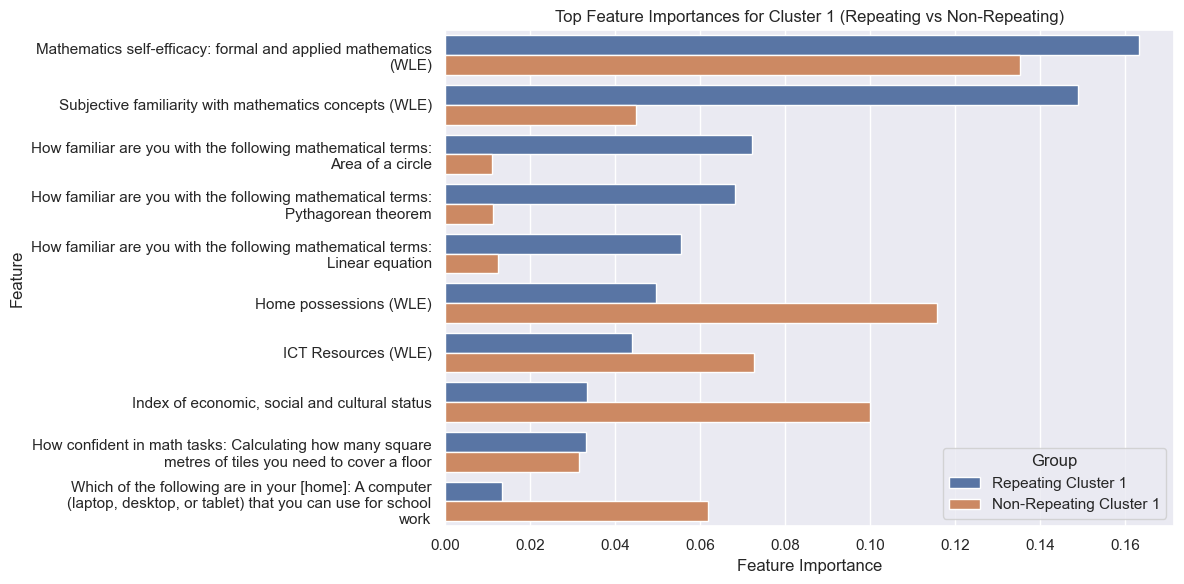

In [14]:
# Cluster 1

X_1_repeating = X_encoded_repeating.copy()
X_1_repeating["cluster_1"] = (X_1_repeating["kmeans"] == 1).astype(int)

X_rep = X_1_repeating.drop(columns=["kmeans", "cluster_1"])
y_rep = X_1_repeating["cluster_1"]

model_rep = RandomForestClassifier(random_state=42)
model_rep.fit(X_rep, y_rep)

importances_rep = pd.Series(model_rep.feature_importances_, index=X_rep.columns)

X_1_not_repeating = X_encoded_not_repeating.copy()
X_1_not_repeating["cluster_1"] = (X_1_not_repeating["kmeans"] == 1).astype(int)

X_nonrep = X_1_not_repeating.drop(columns=["kmeans", "cluster_1"])
y_nonrep = X_1_not_repeating["cluster_1"]

model_nonrep = RandomForestClassifier(random_state=42)
model_nonrep.fit(X_nonrep, y_nonrep)

importances_nonrep = pd.Series(
    model_nonrep.feature_importances_, index=X_nonrep.columns
)

importance_df = pd.DataFrame(
    {
        "Repeating Cluster 1": importances_rep,
        "Non-Repeating Cluster 1": importances_nonrep,
    }
)

top_features = (
    (importances_rep.abs() + importances_nonrep.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)
importance_df = importance_df.loc[top_features]

importance_df = importance_df.sort_values(by="Repeating Cluster 1", ascending=False)

plot_feature_importances(importance_df, cluster_id=1)

Top features obtained for cluster 2, Repeating vs Non-Repeating

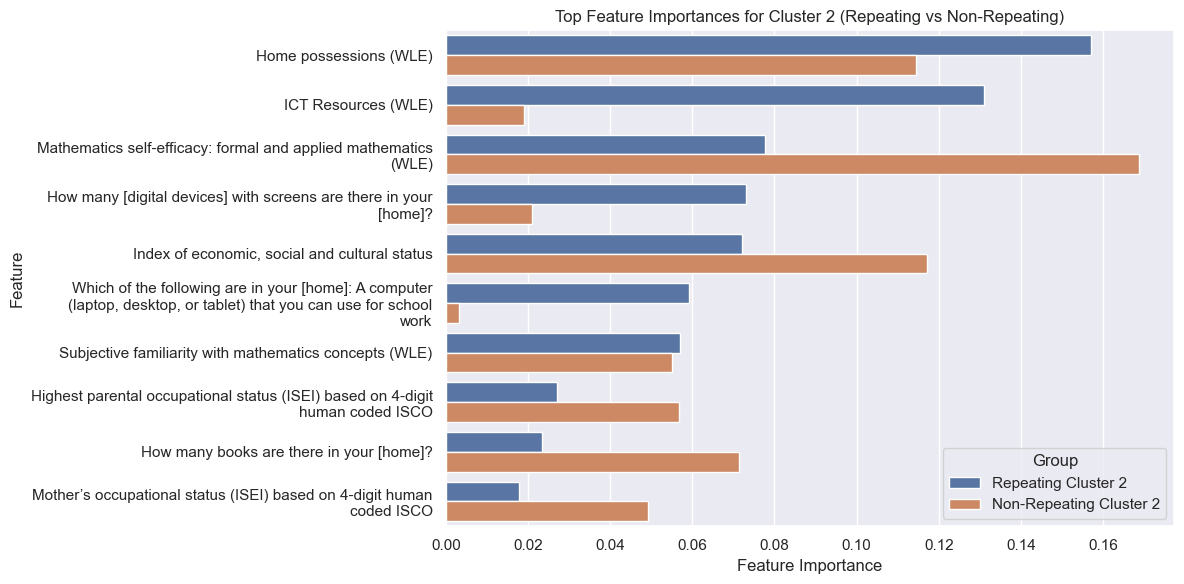

In [15]:
# Cluster 2
cluster = "cluster_2"

X_2_repeating = X_encoded_repeating.copy()
X_2_repeating[cluster] = (X_2_repeating["kmeans"] == 2).astype(int)

X_rep = X_2_repeating.drop(columns=["kmeans", cluster])
y_rep = X_2_repeating[cluster]

model_rep = RandomForestClassifier(random_state=42)
model_rep.fit(X_rep, y_rep)

importances_rep = pd.Series(model_rep.feature_importances_, index=X_rep.columns)

X_2_not_repeating = X_encoded_not_repeating.copy()
X_2_not_repeating[cluster] = (X_2_not_repeating["kmeans"] == 2).astype(int)

X_nonrep = X_2_not_repeating.drop(columns=["kmeans", cluster])
y_nonrep = X_2_not_repeating[cluster]

model_nonrep = RandomForestClassifier(random_state=42)
model_nonrep.fit(X_nonrep, y_nonrep)

importances_nonrep = pd.Series(
    model_nonrep.feature_importances_, index=X_nonrep.columns
)

importance_df = pd.DataFrame(
    {
        "Repeating Cluster 2": importances_rep,
        "Non-Repeating Cluster 2": importances_nonrep,
    }
)

top_features = (
    (importances_rep.abs() + importances_nonrep.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)

importance_df = importance_df.loc[top_features]
importance_df = importance_df.sort_values(by="Repeating Cluster 2", ascending=False)

plot_feature_importances(importance_df, cluster_id=2)

Top features obtained for the entire data, Repeating vs Non-Repeating

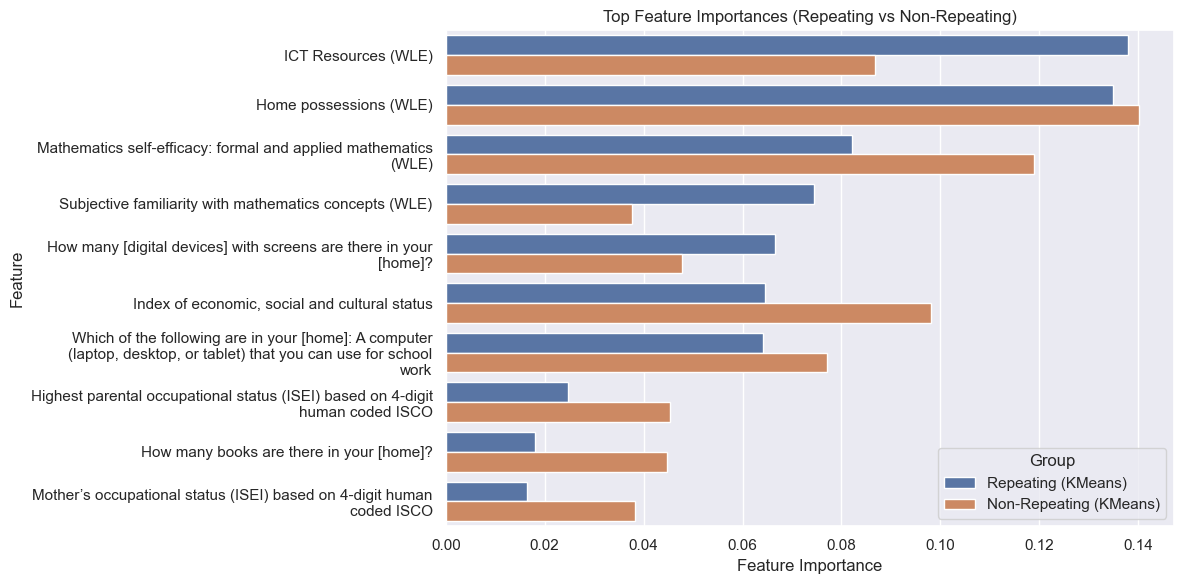

In [16]:
model_rep = RandomForestClassifier(random_state=42)
model_rep.fit(X_encoded_repeating.drop(columns=["kmeans"]), X_encoded_repeating["kmeans"])

importances_rep = pd.Series(
    model_rep.feature_importances_,
    index=X_encoded_repeating.drop(columns=["kmeans"]).columns,
)

model_nonrep = RandomForestClassifier(random_state=42)
model_nonrep.fit(X_encoded_not_repeating.drop(columns=["kmeans"]), X_encoded_not_repeating["kmeans"])

importances_nonrep = pd.Series(
    model_nonrep.feature_importances_,
    index=X_encoded_not_repeating.drop(columns=["kmeans"]).columns,
)

importance_all = pd.DataFrame({
    "Repeating (KMeans)": importances_rep,
    "Non-Repeating (KMeans)": importances_nonrep
})

top_features = (importances_rep.abs() + importances_nonrep.abs()).sort_values(ascending=False).head(10).index

importance_all = importance_all.loc[top_features]
importance_all = importance_all.sort_values(by="Repeating (KMeans)", ascending=False)

plot_feature_importances(importance_all, mapping=column_mapping)

## Step 4 - Linear Regression

To better understand the direction and magnitude of the influence of each variable on student's mathematics performance, a linear regression was conducted based on the most relevant features identified by the previous models.

In this step, we compared each of these variables individually with the Average Math Result by plotting their respective relationships, including ICT Resources, Home Possessions, Mathematics Self-Efficacy, and Familiarity with Mathematical Concepts.

In [35]:
def fill_na_mean(dataset, column_name):
    dataset = dataset.copy()
    mean_value = dataset[column_name].mean()
    dataset[column_name] = dataset[column_name].fillna(mean_value)
    return dataset

In [46]:
def plot_regression(dataset_1, dataset_2, x_col, y_col, title):
    dataset_1 = fill_na_mean(dataset_1, x_col)
    dataset_2 = fill_na_mean(dataset_2, x_col)

    X_rep = dataset_1[[x_col]]
    y_rep = dataset_1[y_col]
    X_nrep = dataset_2[[x_col]]
    y_nrep = dataset_2[y_col]

    model_rep = LinearRegression().fit(X_rep, y_rep)
    model_nrep = LinearRegression().fit(X_nrep, y_nrep)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    sns.regplot(
        x=x_col,
        y=y_col,
        data=dataset_1,
        ax=axes[0],
        scatter_kws={"alpha": 0.3, "color": "steelblue"},
        line_kws={"color": "darkred", "linewidth": 2},
    )
    axes[0].set_title("Repeating Students")
    axes[0].set_xlabel(x_col)
    axes[0].set_ylabel(y_col)
    axes[0].text(
        0.05,
        0.95,
        f"Coefficient: {model_rep.coef_[0]:.4f}",
        transform=axes[0].transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(
            boxstyle="round,pad=0.3", edgecolor="darkred", facecolor="white", alpha=0.8
        ),
    )

    sns.regplot(
        x=x_col,
        y=y_col,
        data=dataset_2,
        ax=axes[1],
        scatter_kws={"alpha": 0.3, "color": "orange"},
        line_kws={"color": "darkgreen", "linewidth": 2},
    )
    axes[1].set_title("Non-Repeating Students")
    axes[1].set_xlabel(x_col)
    axes[1].set_ylabel(y_col)
    axes[1].text(
        0.05,
        0.95,
        f"Coefficient: {model_nrep.coef_[0]:.4f}",
        transform=axes[1].transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(
            boxstyle="round,pad=0.3", edgecolor="darkgreen", facecolor="white", alpha=0.8
        ),
    )
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

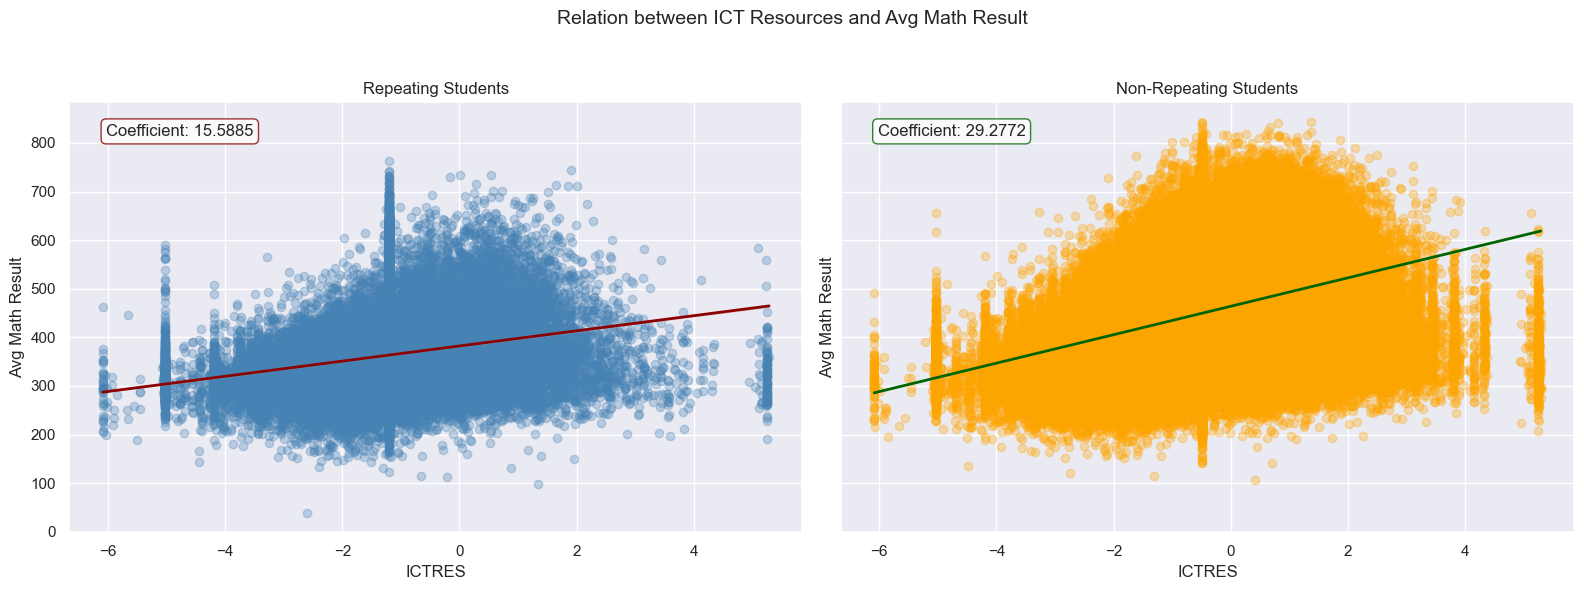

In [37]:
plot_regression(
    repeating,
    not_repeating,
    "ICTRES",
    "Avg Math Result",
    "Relation between ICT Resources and Avg Math Result",
)

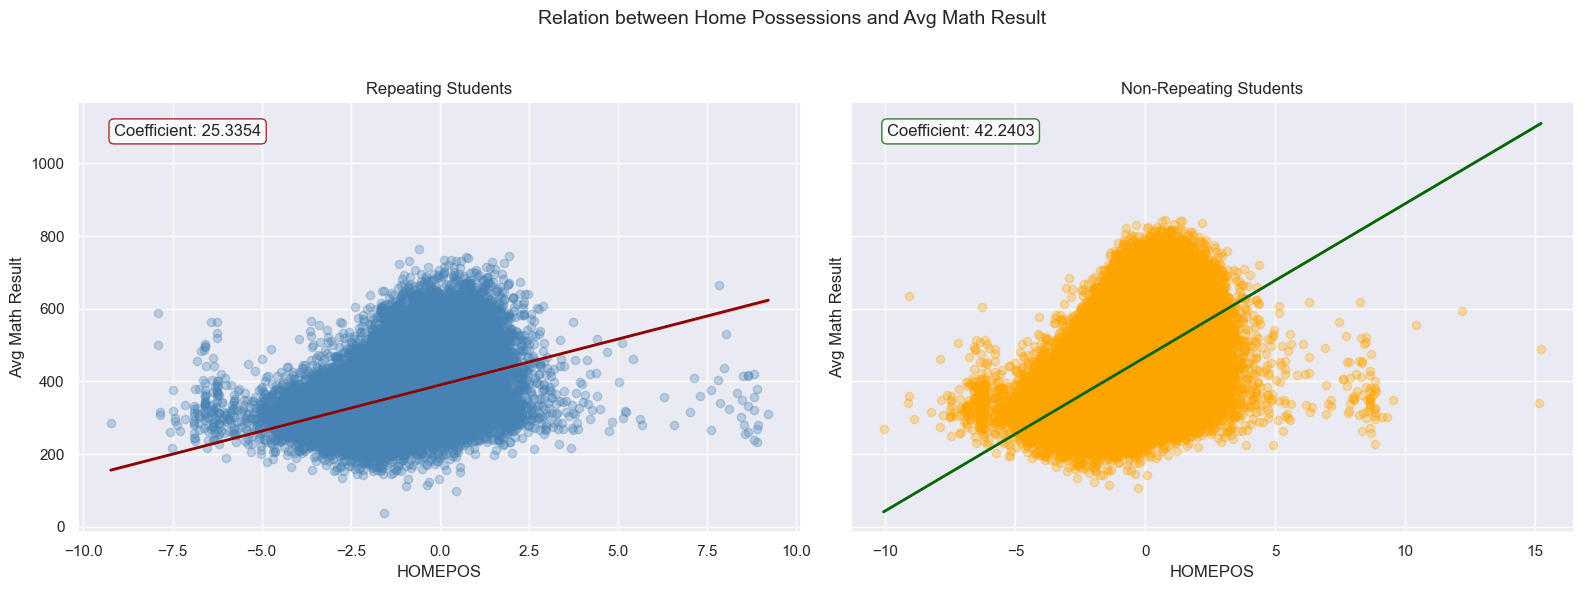

In [38]:
plot_regression(
    repeating,
    not_repeating,
    "HOMEPOS",
    "Avg Math Result",
    "Relation between Home Possessions and Avg Math Result",
)

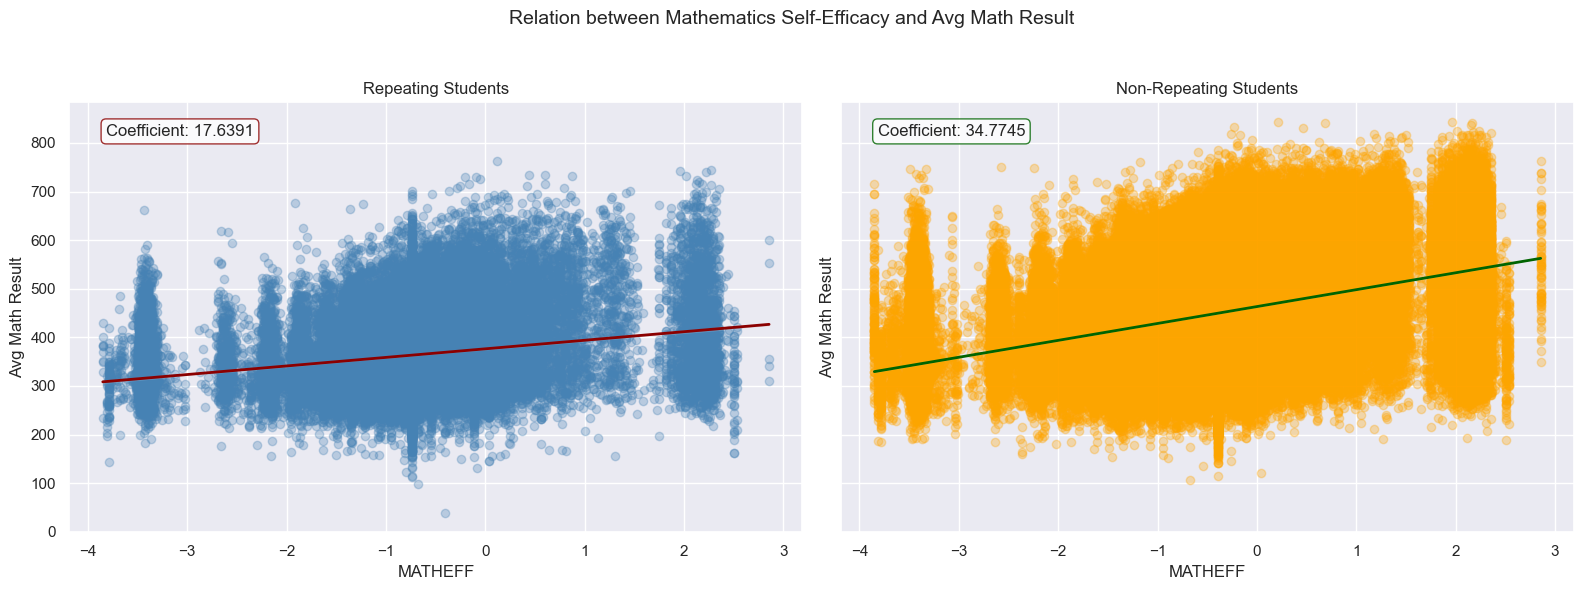

In [39]:
plot_regression(
    repeating,
    not_repeating,
    "MATHEFF",
    "Avg Math Result",
    "Relation between Mathematics Self-Efficacy and Avg Math Result",
)

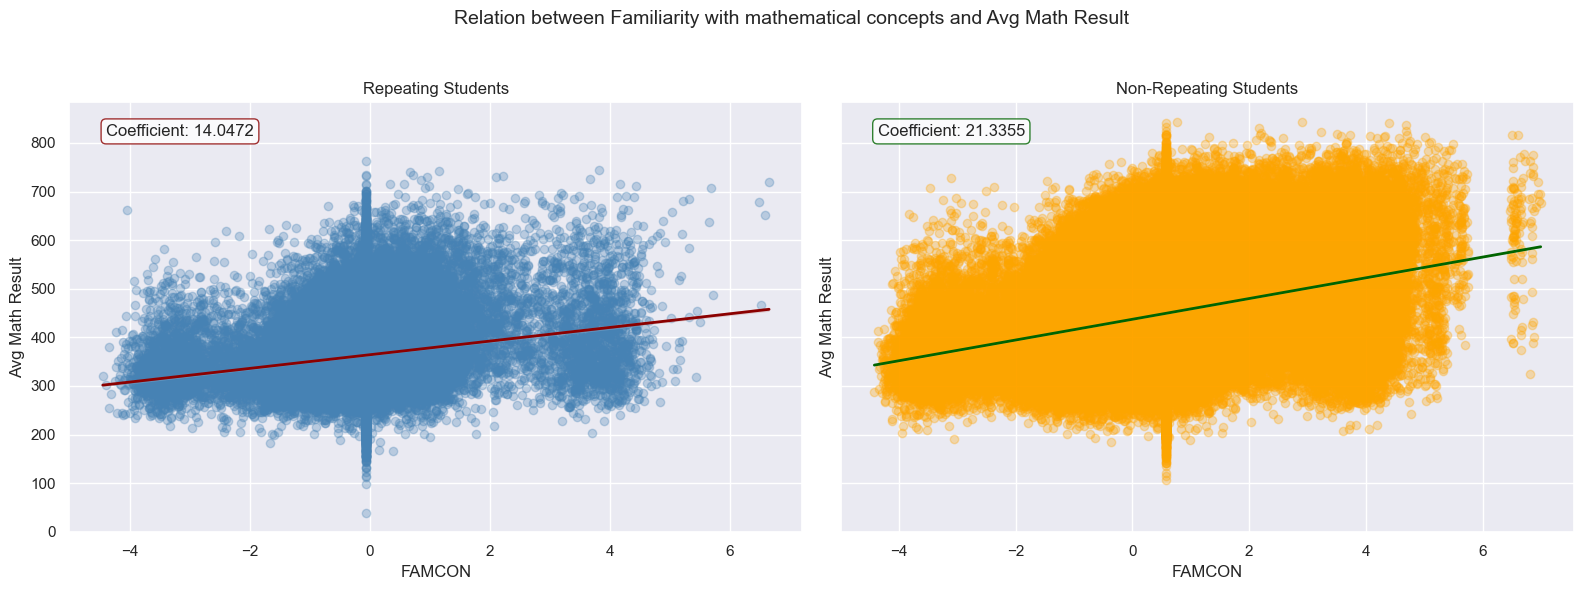

In [47]:
plot_regression(
    repeating,
    not_repeating,
    "FAMCON",
    "Avg Math Result",
    "Relation between Familiarity with mathematical concepts and Avg Math Result",
)